In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns
# pyspark 
import pyspark 
from pyspark.sql import SparkSession 
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import to_date
from pyspark.sql.functions import skewness
from pyspark.sql.functions import sqrt

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType

# import plotly
import plotly.express as px

# import linear model
from sklearn import linear_model

import scipy.stats as stats

sns.set()

In [ ]:
#create instance of spark class 
spark=SparkSession.builder.appName('Weather_prediction').getOrCreate()
  

In [ ]:
spark

In [ ]:
# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "false")

In [ ]:
#create spark dataframe of input csv file 
raw_data=spark.read.csv('weatherHistory.csv'
                  ,inferSchema=True,header=True) 
raw_data.head(1) 

[Row(Formatted Date='2006-04-01 00:00:00.000 +0200', Summary='Partly Cloudy', Precip Type='rain', Temperature (C)=9.472222222222221, Apparent Temperature (C)=7.3888888888888875, Humidity=0.89, Wind Speed (km/h)=14.1197, Wind Bearing (degrees)=251.0, Visibility (km)=15.826300000000002, Loud Cover=0.0, Pressure (millibars)=1015.13, Daily Summary='Partly cloudy throughout the day.')]

<a id='data_preparation'></a>
## 4. Understand and Prepare the Data

<table align="left">
    <tr>
        <td width="8%">
            <img src="key.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                    <b>The process of data preparation entails cleansing, structuring and integrating data to make it ready for analysis. <br><br>
                        Here we will analyze and prepare data :<br>
                        1. Check dimensions and data types of the dataframe <br>
                        2. Statistical Summary<br> 
                        3. Data Cleaning<br> 
                        4. Dealing with outliers<br>
                                       </b>
                </font>
            </div>
        </td>
    </tr>
</table>

<a id='Data_Types'></a>
## 4.1 Data Types and Dimensions

In [ ]:
type(raw_data)


pyspark.sql.dataframe.DataFrame

In [ ]:
raw_data.describe()

DataFrame[summary: string, Formatted Date: string, Summary: string, Precip Type: string, Temperature (C): string, Apparent Temperature (C): string, Humidity: string, Wind Speed (km/h): string, Wind Bearing (degrees): string, Visibility (km): string, Loud Cover: string, Pressure (millibars): string, Daily Summary: string]

In [ ]:
# print schema
raw_data.printSchema()

root
 |-- Formatted Date: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Precip Type: string (nullable = true)
 |-- Temperature (C): double (nullable = true)
 |-- Apparent Temperature (C): double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Wind Speed (km/h): double (nullable = true)
 |-- Wind Bearing (degrees): double (nullable = true)
 |-- Visibility (km): double (nullable = true)
 |-- Loud Cover: double (nullable = true)
 |-- Pressure (millibars): double (nullable = true)
 |-- Daily Summary: string (nullable = true)



In [ ]:
# Column Names
print("\nColumn names :", raw_data.columns)
# Row Count
print("\nNumber of Rows :",raw_data.count()) 
# Column Count
print("\nNumber of features :", len(raw_data.columns))


Column names : ['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover', 'Pressure (millibars)', 'Daily Summary']

Number of Rows : 96453

Number of features : 12


**We see the dataframe has 12 columns and 96453 observations**

<a id='Data_Manipulation'></a>
## 4.2. Data Manipulation


**First, rename the columns so as to make them easy to use**

We will use SQL query to rename columns...

In [ ]:
# Create sql context object 
sqlContext = SQLContext(spark) 
# Register our dataframe as a table
sqlContext.registerDataFrameAsTable(raw_data,'raw_data')

In [ ]:
# Write SQL query
query = '''select `Formatted Date` as Date , Summary , `Precip Type` as Precip_Type , 
        `Temperature (C)` as Temperature , `Apparent Temperature (C)` as Apparent_temp , Humidity , 
        `Wind Speed (km/h)` as Wind_Speed , `Wind Bearing (degrees)` as Wind_Bearing , 
        `Visibility (km)` as Visibility, `Loud Cover` as Cover , `Pressure (millibars)` as Pressure , 
        `Daily Summary` as Daily_Summary from raw_data'''
# Execute query
data_1= sqlContext.sql(query)

In [ ]:
data_1.columns

['Date',
 'Summary',
 'Precip_Type',
 'Temperature',
 'Apparent_temp',
 'Humidity',
 'Wind_Speed',
 'Wind_Bearing',
 'Visibility',
 'Cover',
 'Pressure',
 'Daily_Summary']

In [ ]:
data_1.select('Date').show(5)

+--------------------+
|                Date|
+--------------------+
|2006-04-01 00:00:...|
|2006-04-01 01:00:...|
|2006-04-01 02:00:...|
|2006-04-01 03:00:...|
|2006-04-01 04:00:...|
+--------------------+
only showing top 5 rows



**Now, We will extract month from date**

In [ ]:
# Converting to pandas Dataframe
data = data_1.toPandas()

In [ ]:
#extracting month from date column
data['Date']=pd.to_datetime(data['Date'],utc=True)
data['month']=data['Date'].dt.month
data.head()

,Date,Summary,Precip_Type,Temperature,Apparent_temp,Humidity,Wind_Speed,Wind_Bearing,Visibility,Cover,Pressure,Daily_Summary,month
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,3
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,3
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,4
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,4
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,4


In [ ]:
# Nowing Converting pandas Dataframe into Spark Dataframe
data_2 = spark.createDataFrame(data)
data_2.head(1)

[Row(Date=datetime.datetime(2006, 4, 1, 3, 30), Summary='Partly Cloudy', Precip_Type='rain', Temperature=9.472222222222221, Apparent_temp=7.3888888888888875, Humidity=0.89, Wind_Speed=14.1197, Wind_Bearing=251.0, Visibility=15.826300000000002, Cover=0.0, Pressure=1015.13, Daily_Summary='Partly cloudy throughout the day.', month=3)]

In [ ]:
data_2.columns

['Date',
 'Summary',
 'Precip_Type',
 'Temperature',
 'Apparent_temp',
 'Humidity',
 'Wind_Speed',
 'Wind_Bearing',
 'Visibility',
 'Cover',
 'Pressure',
 'Daily_Summary',
 'month']

<a id='Statistical_Summary'></a>
## 4.3. Statistical Summary
Here we take a look at the summary of each attribute. This includes the count, mean, the min and max values as well as some percentiles for numeric variables.

<table align="left">
    <tr>
        <td width="8%">
            <img src="key.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                    <b> In our dataset we have numerical variables. Now we check for summary statistics of all the variables<br>
                        For numerical variables, we use .describe().show(). For categorical variables we use describe(include='object').
          <br>
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
data_2.describe(['Humidity', 'Wind_Speed', 'Temperature', 'Apparent_temp']).show()

+-------+------------------+------------------+-------------------+-------------------+
|summary|          Humidity|        Wind_Speed|        Temperature|      Apparent_temp|
+-------+------------------+------------------+-------------------+-------------------+
|  count|             96453|             96453|              96453|              96453|
|   mean|0.7348989663359295|10.810640140794051| 11.932678437511974| 10.855028874166754|
| stddev|0.1954727390672154| 6.913571012591993|  9.551546320657023| 10.696847392119196|
|    min|               0.0|               0.0|-21.822222222222223|-27.716666666666665|
|    max|               1.0|63.852599999999995|  39.90555555555555|  39.34444444444444|
+-------+------------------+------------------+-------------------+-------------------+



In [ ]:
data_2.describe(['Wind_Bearing', 'Visibility', 'Cover', 'Pressure', 'month']).show()

+-------+------------------+------------------+-----+------------------+-----------------+
|summary|      Wind_Bearing|        Visibility|Cover|          Pressure|            month|
+-------+------------------+------------------+-----+------------------+-----------------+
|  count|             96453|             96453|96453|             96453|            96453|
|   mean|187.50923247592092|10.347324929238823|  0.0|1003.2359558541469|6.523000839787254|
| stddev| 107.3834283807058| 4.192123191422789|  0.0|116.96990568258026|3.448500531876499|
|    min|               0.0|               0.0|  0.0|               0.0|                1|
|    max|             359.0|              16.1|  0.0|           1046.38|               12|
+-------+------------------+------------------+-----+------------------+-----------------+



<table align="left">
    <tr>
        <td width="8%">
            <img src="note.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
<b>The above output illustrates the summary statistics of all the numeric variables.
                </b>     </font>
            </div>
        </td>
    </tr>
</table>

**Drop unneccesary columns**

In [ ]:
# Drop date feature and Daily Summary
data_3 = data_2.drop('Date','Daily_Summary')
data_3.columns

['Summary',
 'Precip_Type',
 'Temperature',
 'Apparent_temp',
 'Humidity',
 'Wind_Speed',
 'Wind_Bearing',
 'Visibility',
 'Cover',
 'Pressure',
 'month']

<table align="left">
    <tr>
        <td width="8%">
            <img src="note.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
<b>Since, We have extracted month from Date and Daily Summary shows same stats as that of Summary we removed them 
                </b>     </font>
            </div>
        </td>
    </tr>
</table>

<a id='Label_Encoding_Categorical_Data'></a>
## 4.4. Label Encoding Categorical Data

In [ ]:
data_3.select('Precip_Type').distinct().show()

+-----------+
|Precip_Type|
+-----------+
|       rain|
|       snow|
|       null|
+-----------+



**Encoding Precip_Type feature - rain : 0 and snow : 1**

In [ ]:
# Creating a String Indexer Object
indexer = StringIndexer(inputCol="Precip_Type", outputCol="Precip_Type_encoded") 

In [ ]:
# Fitting StringIndexer Object
data_4 = indexer.fit(data_3).transform(data_3) 

In [ ]:
data_4.select('Precip_Type_encoded').distinct().show()

+-------------------+
|Precip_Type_encoded|
+-------------------+
|                0.0|
|                1.0|
|                2.0|
+-------------------+



In [ ]:
data_4 = data_4.drop('Precip_Type')

<table align="left">
    <tr>
        <td width="8%">
            <img src="note.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
<b>We can see that rain, snow and null is encoded as 0, 1, and 2</b>     </font>
            </div>
        </td>
    </tr>
</table>

Now, we will replace 2 with NULL

In [ ]:
data_4.select('Precip_Type_encoded').replace([2],[np.nan]).distinct().show()

+-------------------+
|Precip_Type_encoded|
+-------------------+
|                0.0|
|                NaN|
|                1.0|
+-------------------+



In [ ]:
data_4.select('Precip_Type_encoded').replace([2],[np.nan]).distinct().show()


+-------------------+
|Precip_Type_encoded|
+-------------------+
|                0.0|
|                NaN|
|                1.0|
+-------------------+



In [ ]:
data_5 = data_4.select('*')
data_5.printSchema()

root
 |-- Summary: string (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Apparent_temp: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Wind_Speed: double (nullable = true)
 |-- Wind_Bearing: double (nullable = true)
 |-- Visibility: double (nullable = true)
 |-- Cover: double (nullable = true)
 |-- Pressure: double (nullable = true)
 |-- month: long (nullable = true)
 |-- Precip_Type_encoded: double (nullable = false)



In [ ]:
def valueToEncode(value):
    if   value == 0 : 
            return 0
    elif value == 1 : 
        return 1
    else: 
        return np.nan



In [ ]:
udfValueToInteger = udf(valueToEncode, IntegerType())

In [ ]:
data_6 = data_5.withColumn("Precip_Type", udfValueToInteger("Precip_Type_encoded"))
data_6 = data_6.drop('Precip_Type_encoded')

In [ ]:
data_6.select('Precip_Type').distinct().show()

+-----------+
|Precip_Type|
+-----------+
|       null|
|          1|
|          0|
+-----------+



**Encoding Summary**

In [ ]:
data_6.select('Summary').distinct().show()

+--------------------+
|             Summary|
+--------------------+
|              Breezy|
|Humid and Mostly ...|
|  Windy and Overcast|
|               Foggy|
|Humid and Partly ...|
|     Windy and Foggy|
|Breezy and Partly...|
|                 Dry|
|             Drizzle|
|      Breezy and Dry|
|       Partly Cloudy|
|               Clear|
|       Windy and Dry|
|       Mostly Cloudy|
|    Breezy and Foggy|
| Breezy and Overcast|
|Dangerously Windy...|
|          Light Rain|
|Breezy and Mostly...|
|Dry and Mostly Cl...|
+--------------------+
only showing top 20 rows



In [ ]:
data = data_6.toPandas()

In [ ]:
print(data['Summary'].value_counts())

Partly Cloudy                          31733
Mostly Cloudy                          28094
Overcast                               16597
Clear                                  10890
Foggy                                   7148
Breezy and Overcast                      528
Breezy and Mostly Cloudy                 516
Breezy and Partly Cloudy                 386
Dry and Partly Cloudy                     86
Windy and Partly Cloudy                   67
Light Rain                                63
Breezy                                    54
Windy and Overcast                        45
Humid and Mostly Cloudy                   40
Drizzle                                   39
Breezy and Foggy                          35
Windy and Mostly Cloudy                   35
Dry                                       34
Humid and Partly Cloudy                   17
Dry and Mostly Cloudy                     14
Rain                                      10
Windy                                      8
Humid and 

In [ ]:
#label encoding summary type column
data['Summary']=data['Summary'].replace(data['Summary'].unique(),range(0,len(data['Summary'].unique())))
print(data['Summary'].value_counts())

0     31733
1     28094
2     16597
5     10890
3      7148
7       528
4       516
6       386
15       86
13       67
21       63
14       54
11       45
8        40
22       39
16       35
12       35
18       34
9        17
24       14
26       10
19        8
20        7
10        4
17        1
25        1
23        1
Name: Summary, dtype: int64


In [ ]:
data_7 = spark.createDataFrame(data)

In [ ]:
data_7.printSchema()

root
 |-- Summary: long (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Apparent_temp: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Wind_Speed: double (nullable = true)
 |-- Wind_Bearing: double (nullable = true)
 |-- Visibility: double (nullable = true)
 |-- Cover: double (nullable = true)
 |-- Pressure: double (nullable = true)
 |-- month: long (nullable = true)
 |-- Precip_Type: double (nullable = true)



In [ ]:
data_7.select('Summary').distinct().show()

+-------+
|Summary|
+-------+
|     26|
|     19|
|      0|
|     22|
|      7|
|     25|
|      6|
|      9|
|     17|
|      5|
|      1|
|     10|
|      3|
|     12|
|      8|
|     11|
|      2|
|      4|
|     13|
|     18|
+-------+
only showing top 20 rows



In [ ]:
data_encoded = data_7.select('*')

<a id='Dealing_with_missing_values'></a>
## 4.5. Dealing with missing values

<table align="left">
    <tr>
        <td width="8%">
            <img src="key.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                    <b>In order to handle missing values we will follow following steps:<br>
                        1. Convert spark dataframe to pandas<br>
                        2. Compute missing values using KNN imputer<br> 
                        3. Convert pandas dataframe back to spark sql dataframe<br> 
                                       </b>
                </font>
            </div>
        </td>
    </tr>
</table>

**Checking for Missing values**

In [ ]:
data_encoded.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data_encoded.columns]).show()

+-------+-----------+-------------+--------+----------+------------+----------+-----+--------+-----+-----------+
|Summary|Temperature|Apparent_temp|Humidity|Wind_Speed|Wind_Bearing|Visibility|Cover|Pressure|month|Precip_Type|
+-------+-----------+-------------+--------+----------+------------+----------+-----+--------+-----+-----------+
|      0|          0|            0|       0|         0|           0|         0|    0|       0|    0|        517|
+-------+-----------+-------------+--------+----------+------------+----------+-----+--------+-----+-----------+



<table align="left">
    <tr>
        <td width="8%">
            <img src="note.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
<b>There are missing values in the dataset</b>     </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
data_no_na = data_encoded.where(data_encoded.Precip_Type != np.nan)

Checking for missing values

In [ ]:
data_no_na.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data_no_na.columns]).show()

+-------+-----------+-------------+--------+----------+------------+----------+-----+--------+-----+-----------+
|Summary|Temperature|Apparent_temp|Humidity|Wind_Speed|Wind_Bearing|Visibility|Cover|Pressure|month|Precip_Type|
+-------+-----------+-------------+--------+----------+------------+----------+-----+--------+-----+-----------+
|      0|          0|            0|       0|         0|           0|         0|    0|       0|    0|          0|
+-------+-----------+-------------+--------+----------+------------+----------+-----+--------+-----+-----------+



<table align="left">
    <tr>
        <td width="8%">
            <img src="note.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
<b>There are no missing values</b>     </font>
            </div>
        </td>
    </tr>
</table>

<a id='EDA'></a>
## 5. EDA

<table align="left">
    <tr>
        <td width="8%">
            <img src="key.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                    <b>The process of EDA is to analysis the data.<br><br>
                        </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In EDA we analyse feature in depth and try to extract some key insights from it. <br>
**Analysis is done by checking outliear, boxplot and histograms**

**Creating functions to plot boxplot, scatter plot and histograms**

In [ ]:
def plot_feature(data , feature):
    df = data.select(feature).toPandas()
    df['Apparent_temp'] = data.select('Apparent_temp').toPandas()
    fig_dims = (15, 6)
    fig, axs = plt.subplots(ncols=2 , figsize=fig_dims)
    sns.boxplot(x = df[feature] , ax=axs[0]).set_title('Boxplot of ' + feature)
    sns.histplot(x = feature , data = df , ax=axs[1])
    sns.catplot(x=feature, data=df)
    g = sns.jointplot(y = 'Apparent_temp' , x = feature , data = df , kind= "reg" , joint_kws={'line_kws':{'color':'red'}})
    
    

In [ ]:
# Create a function to remove outliers
def remove_outliers(data , feature):
    range_itr = data.approxQuantile(feature, [0.25, 0.75], 0)
    iqr = range_itr[1] - range_itr[0]
    lower_bond = range_itr[0] - 1.5 * iqr
    upper_bond = range_itr[1] + 1.5 * iqr
    return data.filter((data[feature] >= lower_bond) & (data[feature] <= upper_bond))


In [ ]:
# Create a function to check for outliers
def check_outliers(data , feature):
    max_value = max(data.select(feature).toPandas()[feature])
    min_value = min(data.select(feature).toPandas()[feature])
    range_itr = data.approxQuantile(feature, [0.25, 0.75], 0)
    iqr = range_itr[1] - range_itr[0]
    lower_bond = range_itr[0] - 1.5 * iqr
    upper_bond = range_itr[1] + 1.5 * iqr
    if(lower_bond > min_value or upper_bond < max_value ):
        return "Outliers are present"
    else:
        return "Outliers are absent"


In [ ]:
# Creating a function to make a categorical feature
def plot_categorical(data , feature):
    df = data.select(feature).toPandas()
    df['Apparent_temp'] = data.select('Apparent_temp').toPandas()
    ax = sns.countplot(y=feature, data=df)
    plt.title('Distribution of ' + feature)
    plt.xlabel('Count')

    total = len(df[feature])
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))

    plt.show()



**1. Analysis of Temperature**

In [ ]:
data_df = data_no_na
feature = 'Temperature'

In [ ]:
data_df.select(feature).summary().show()

+-------+-------------------+
|summary|        Temperature|
+-------+-------------------+
|  count|              96453|
|   mean| 11.932678437511974|
| stddev|  9.551546320657023|
|    min|-21.822222222222223|
|    25%|  4.683333333333334|
|    50%|               12.0|
|    75%|  18.83888888888889|
|    max|  39.90555555555555|
+-------+-------------------+



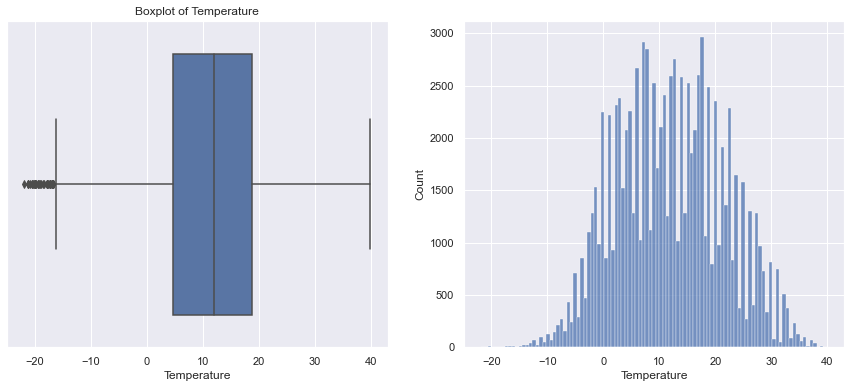

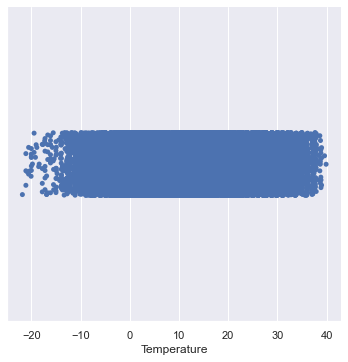

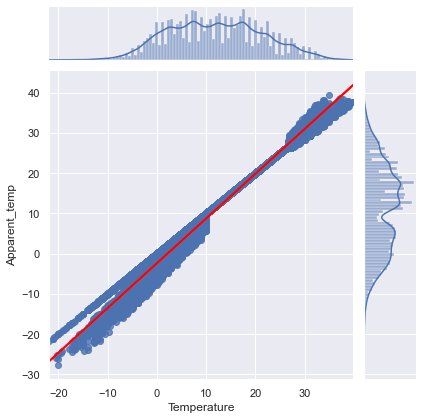

In [ ]:
plot_feature(data=data_df,feature=feature)

**There are outliers at the lower end**

In [ ]:
check_outliers(data=data_df , feature=feature)

'Outliers are present'

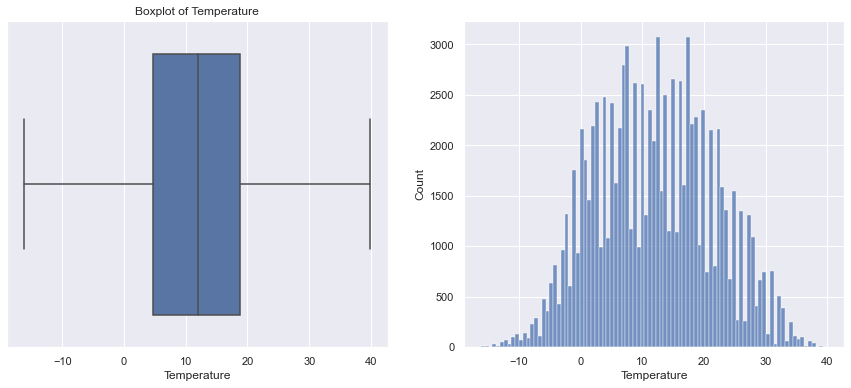

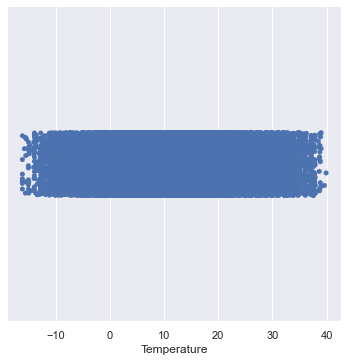

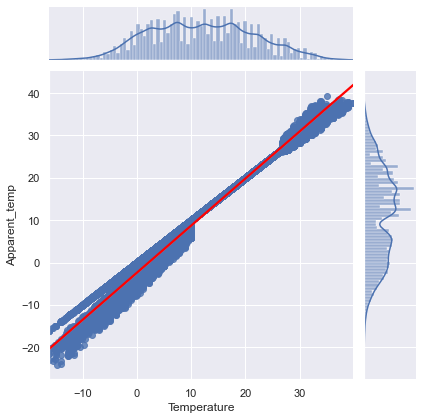

In [ ]:
plot_feature(data=data1,feature=feature)

In [ ]:
# Get first quantile and Second quantile
quantile_range = data_df.approxQuantile(feature, [0.25, 0.75], 0)
print(quantile_range)
# Calcualting Inter Quantile range
iqr = quantile_range[1] - quantile_range[0]
print(iqr)

[4.688888888888887, 18.83888888888889]
14.150000000000002


In [ ]:
# Getting Lower bond 
lower_bond = quantile_range[0] - 1.5 * iqr
print(lower_bond)

-16.536111111111115


In [ ]:
sqlContext = SQLContext(spark)
sqlContext.registerDataFrameAsTable(data_no_na,'mytable')
data1 = sqlContext.sql("SELECT * from mytable where Temperature > " + str(lower_bond))

In [ ]:
# Let's check for outliers again
check_outliers(data=data1 , feature=feature)

'Outliers are absent'

**Conclusion**

* There where outliers which got handled
* We can clearly see that there is a linear relationship between Temperature of Air and Apparent temperature
* Temperature is normally distributed

**2. Analysis of Humidity**

In [ ]:
data_df = data1
feature = 'Humidity'

In [ ]:
data_df.select(feature).summary().show()

+-------+------------------+
|summary|          Humidity|
+-------+------------------+
|  count|             96409|
|   mean|0.7348976755282126|
| stddev|  0.19545171652228|
|    min|               0.0|
|    25%|               0.6|
|    50%|              0.78|
|    75%|              0.89|
|    max|               1.0|
+-------+------------------+



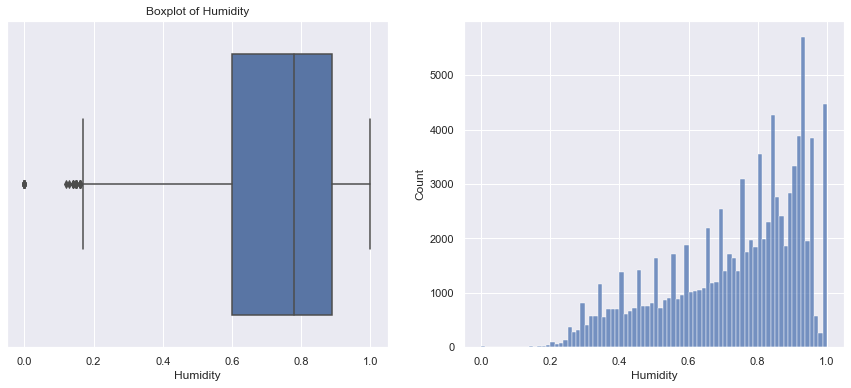

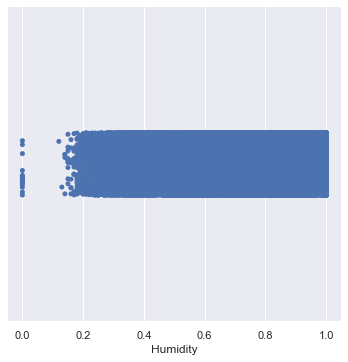

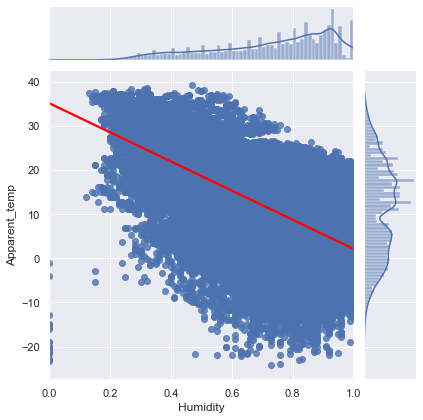

In [ ]:
plot_feature(data=data_df,feature=feature)

**There are outliers**

In [ ]:
# Let's check for outliers 
check_outliers(data=data_df , feature=feature)

'Outliers are present'

In [ ]:
# Remove outliers
data2 = remove_outliers(data=data_df , feature=feature)

In [ ]:
# Let's check for outliers again
check_outliers(data=data2 , feature=feature)

'Outliers are absent'

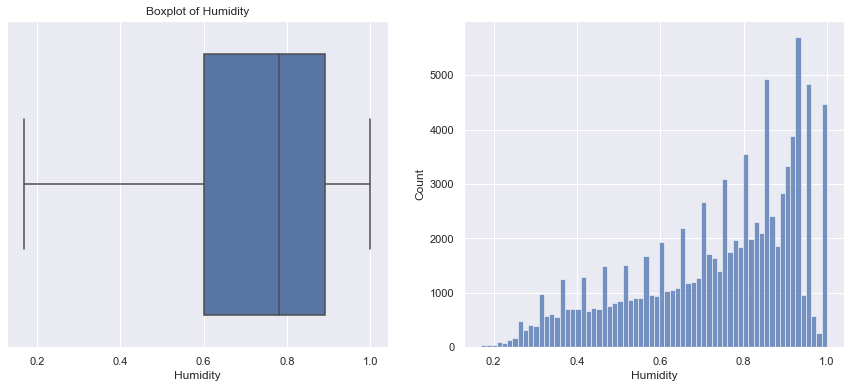

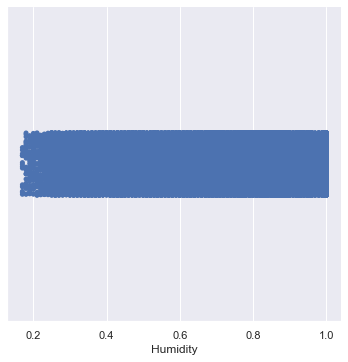

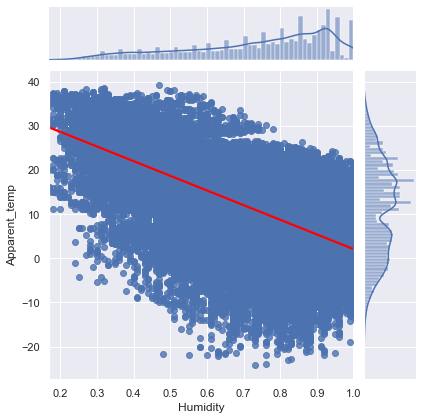

In [ ]:
plot_feature(data=data2,feature=feature)

**Conclusion from above analysis**

* There where few outliears, which are got dropped
* Humidity have slight inverse relationship with Apparent Temperature
* Humidity can be normalized by applying Scaler


**3. Analysis of Wind_Speed**

In [ ]:
data_df = data2
feature = 'Wind_Speed'

In [ ]:
data_df.select(feature).summary().show()

+-------+------------------+
|summary|        Wind_Speed|
+-------+------------------+
|  count|             96367|
|   mean|10.811045832079534|
| stddev|6.9122676594407295|
|    min|               0.0|
|    25%| 5.828200000000001|
|    50%| 9.965900000000001|
|    75%|           14.1358|
|    max|63.852599999999995|
+-------+------------------+



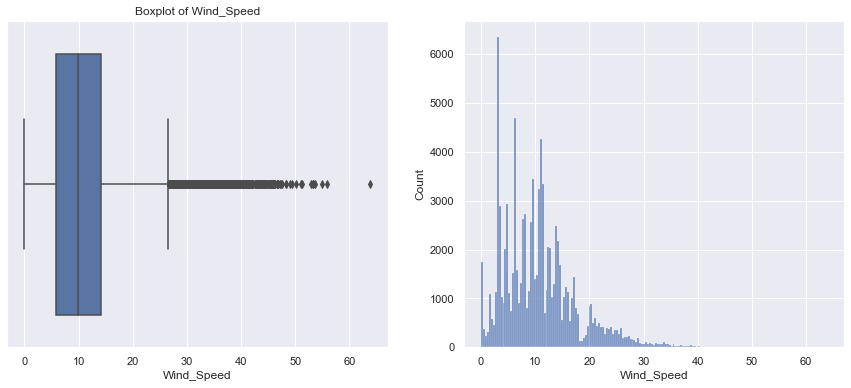

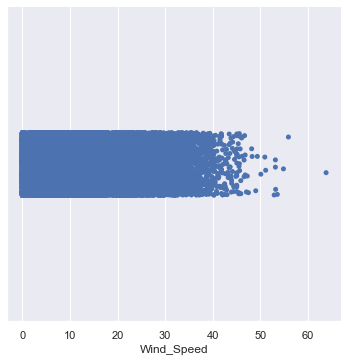

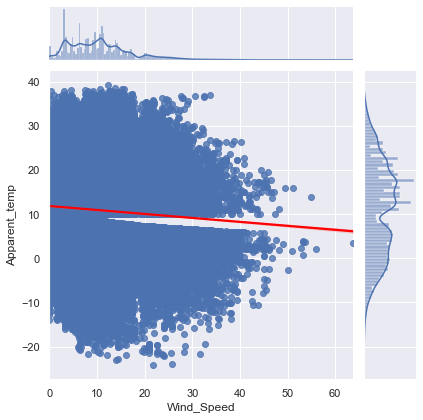

In [ ]:
plot_feature(data=data_df,feature=feature)

**There are outliers**

In [ ]:
# Let's check for outliers 
check_outliers(data=data_df , feature=feature)

'Outliers are present'

In [ ]:
# Remove outliers
data3 = remove_outliers(data=data_df , feature=feature)

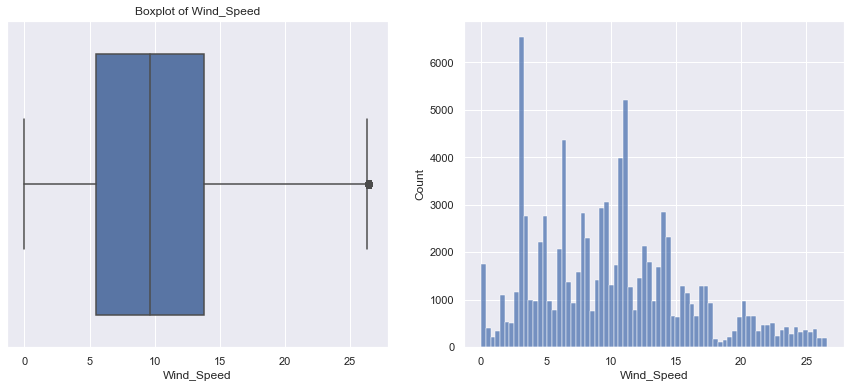

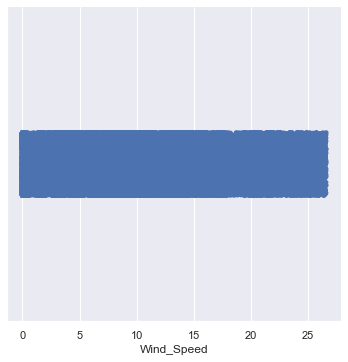

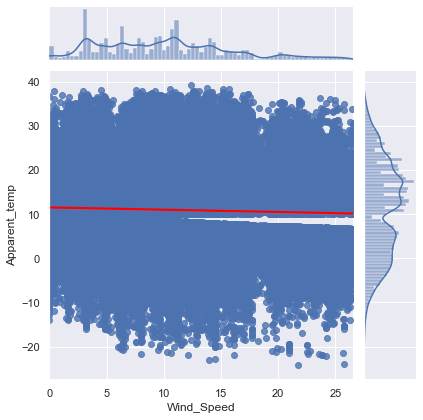

In [ ]:
plot_feature(data=data3,feature=feature)

**Conclusion from above analysis**

* There where few outliears which got removed
* Wind Speed doesn't explain much about Apparent Temperature according to the plot

**4. Analysis of Wind_Bearing**

In [ ]:
data_df = data3
feature = 'Wind_Bearing'

In [ ]:
data_df.select(feature).summary().show()

+-------+------------------+
|summary|      Wind_Bearing|
+-------+------------------+
|  count|             93343|
|   mean|186.27074338729204|
| stddev|107.23076134437996|
|    min|               0.0|
|    25%|             112.0|
|    50%|             180.0|
|    75%|             289.0|
|    max|             359.0|
+-------+------------------+



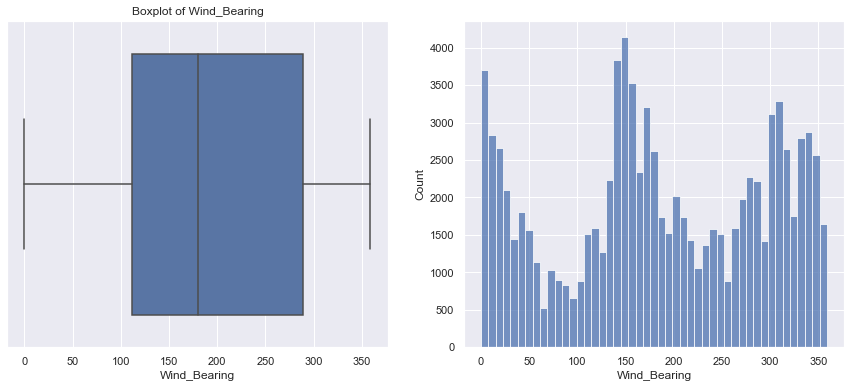

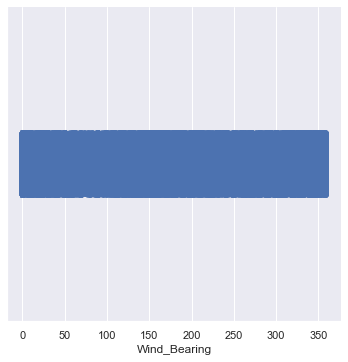

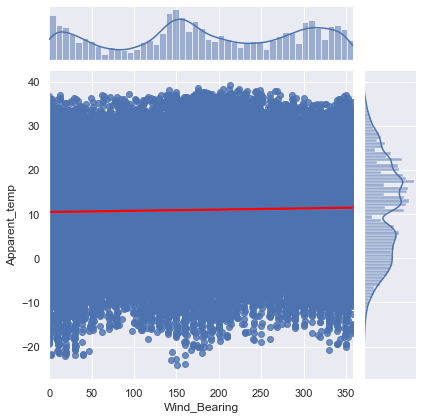

In [ ]:
plot_feature(data=data_df,feature=feature)

**Conclusion from above analysis**

* There are no outliears
* Wind Bearing is concentrated between 110 degrees to 280 degrees

**5. Analysis of Visibility**

In [ ]:
data_df = data3
feature = 'Visibility'

In [ ]:
data_df.select(feature).summary().show()

+-------+------------------+
|summary|        Visibility|
+-------+------------------+
|  count|             93343|
|   mean| 10.32909632323674|
| stddev| 4.221054827318569|
|    min|               0.0|
|    25%|            8.1949|
|    50%|           10.0303|
|    75%|14.876400000000002|
|    max|              16.1|
+-------+------------------+



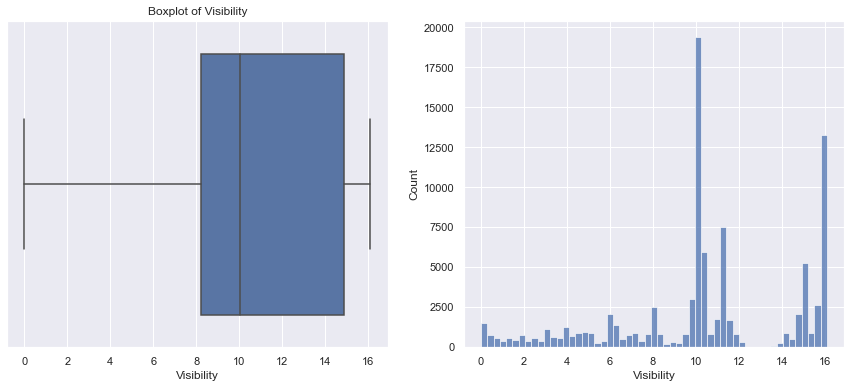

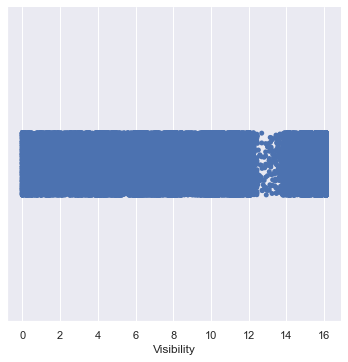

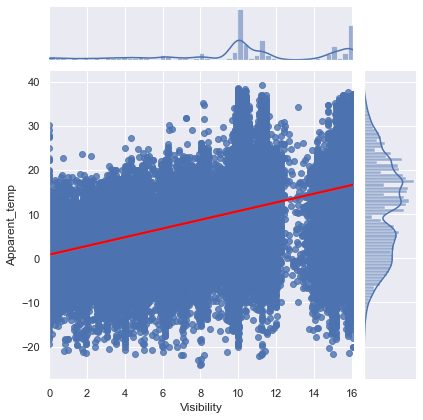

In [ ]:
plot_feature(data=data_df,feature=feature)

**Conclusion from above analysis**

* There are no outliears
* And as Visibility increase mostly Apparent temperature also increases
* Visibility extend from 0 to 16 Kilometer


**6. Analysis of Pressure**

In [ ]:
data_df = data3
feature = 'Pressure'

In [ ]:
data_df.select(feature).summary().show()

+-------+------------------+
|summary|          Pressure|
+-------+------------------+
|  count|             93343|
|   mean|1003.9688764020864|
| stddev|114.53638472328358|
|    min|               0.0|
|    25%|           1012.09|
|    50%|           1016.56|
|    75%|           1021.17|
|    max|           1046.38|
+-------+------------------+



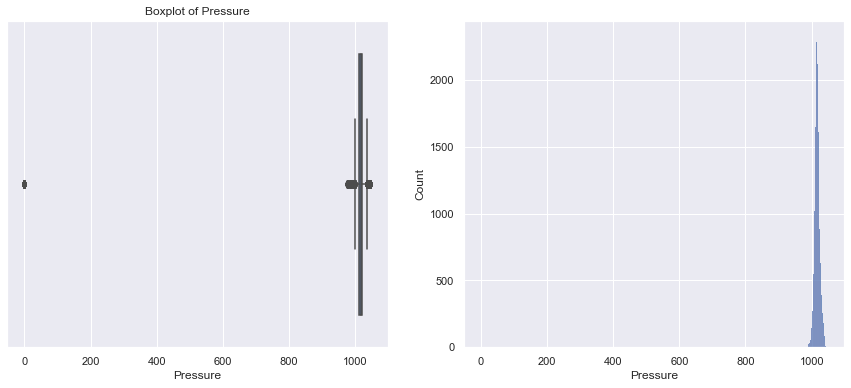

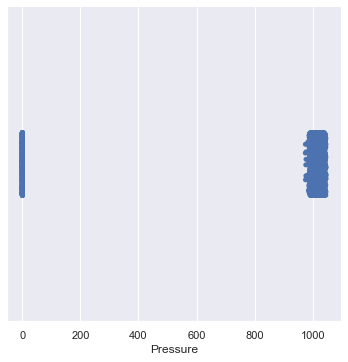

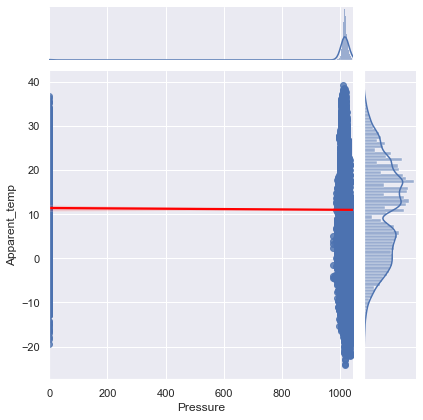

In [ ]:
plot_feature(data=data_df , feature= feature)

In [ ]:
data_df.select(skewness(data_df[feature])).show()

+------------------+
|skewness(Pressure)|
+------------------+
|-8.612093774747061|
+------------------+



**Conclusion from above analysis**

* Pressure is has negeative skewness which can be removed by applying square root

**7. Analysis of month**

In [ ]:
data_df = data3
feature = 'month'

In [ ]:
data_df.select(feature).summary().show()

+-------+-----------------+
|summary|            month|
+-------+-----------------+
|  count|            93343|
|   mean|6.554160461952155|
| stddev|3.431515527110786|
|    min|                1|
|    25%|                4|
|    50%|                7|
|    75%|               10|
|    max|               12|
+-------+-----------------+



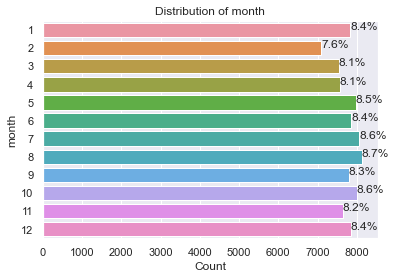

In [ ]:
plot_categorical(data=data_df,feature=feature)

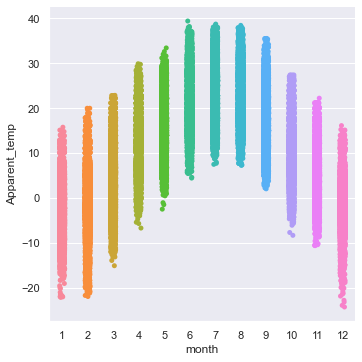

In [ ]:
sns.catplot(x="month", y="Apparent_temp", data=data_df.toPandas(), )

**Conclusion from above analysis**

* Month is almost equally distributed
* We can see that Apparent temperature increase and then decreases
* Month follows a wave curve with respect to Apparent Temperature

**8. Analysis of Precip_Type**

In [ ]:
data_df = data3
feature = 'Precip_Type'

In [ ]:
data_df.select(feature).summary().show()

+-------+-------------------+
|summary|        Precip_Type|
+-------+-------------------+
|  count|              92843|
|   mean|0.11197397757504604|
| stddev| 0.3153361332655498|
|    min|                0.0|
|    25%|                0.0|
|    50%|                0.0|
|    75%|                0.0|
|    max|                1.0|
+-------+-------------------+



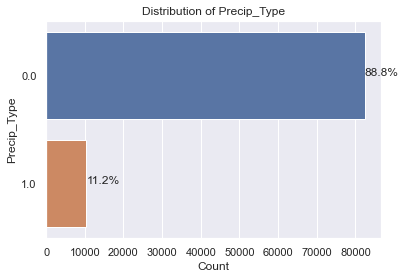

In [ ]:
plot_categorical(data=data_df,feature=feature)

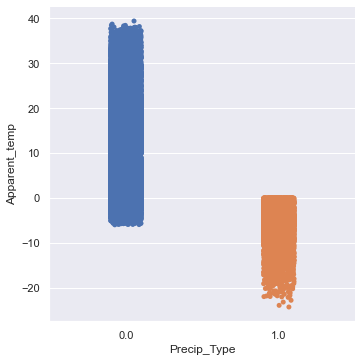

In [ ]:
sns.catplot(x=feature, y="Apparent_temp", data=data_df.toPandas())

**Conclusion from above analysis**

* As we can see that temperatures while it is snow is less and high when it is raining
* Dataframe consists of majority of rain 

**9. Analysis of Summary**

In [ ]:
data_df = data3
feature = 'Summary'

In [ ]:
data_df.select(feature).summary().show()

+-------+-----------------+
|summary|          Summary|
+-------+-----------------+
|  count|            92843|
|   mean|1.500770117294788|
| stddev|1.822545540979885|
|    min|                0|
|    25%|                0|
|    50%|                1|
|    75%|                2|
|    max|               26|
+-------+-----------------+



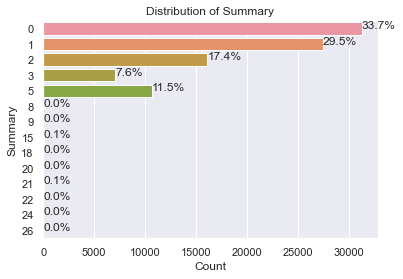

In [ ]:
plot_categorical(data=data_df,feature=feature)

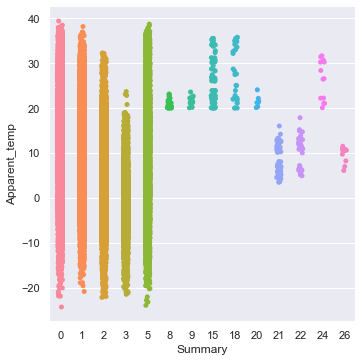

In [ ]:
sns.catplot(x=feature, y="Apparent_temp", data=data_df.toPandas())

**10. Analysis of Cover**

In [ ]:
data_df = data3
feature = 'Cover'

In [ ]:
data_df.select(feature).summary().show()

+-------+-----+
|summary|Cover|
+-------+-----+
|  count|92843|
|   mean|  0.0|
| stddev|  0.0|
|    min|  0.0|
|    25%|  0.0|
|    50%|  0.0|
|    75%|  0.0|
|    max|  0.0|
+-------+-----+



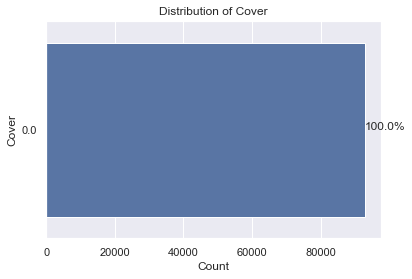

In [ ]:
plot_categorical(data=data_df,feature=feature)

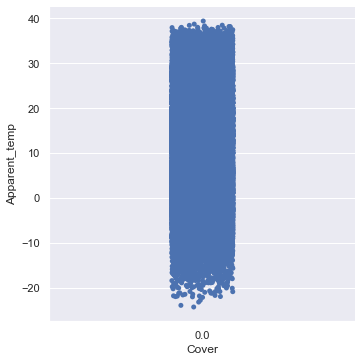

In [ ]:
sns.catplot(x=feature, y="Apparent_temp", data=data_df.toPandas())

**Conclusion from above analysis**

* Dataframe have only one category for Cover, hence it should be dropped

In [ ]:
# Droping Cover
data4 = data3.drop('Cover')

### Before moving a head let's remove skewness from Pressure feature

In [ ]:
# Create sql context object 
sqlContext = SQLContext(spark) 
# Register our dataframe as a table
sqlContext.registerDataFrameAsTable(data4,'data4')
# Write SQL query
query = '''select * from data4 where Pressure > 0'''
# Execute query
data5 = sqlContext.sql(query)

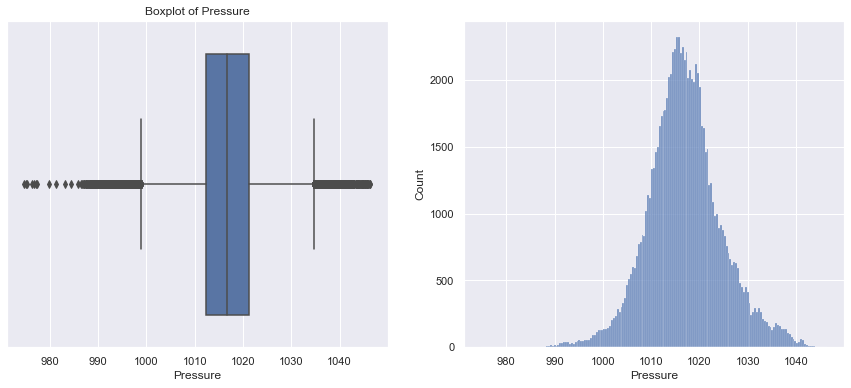

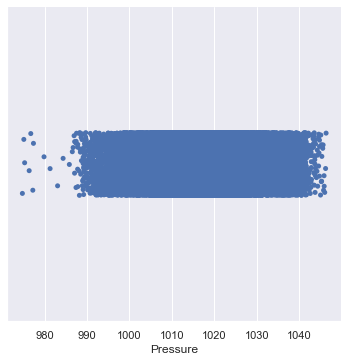

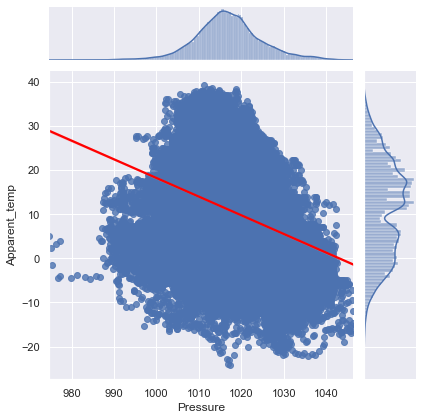

In [ ]:
plot_feature(data5,'Pressure')

We can see that pressure is now normally distributed

<a id='Correlation'></a>
## 6. Correlation



<table align="left">
    <tr>
        <td width="8%">
            <img src="key.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <b> In order to To check correlation and plot heatmap in spark<br></b>
                        1. Build a Vector Assembler in pyspark to merge all features into a single list<br>
                        2. Transform using dataframe using vector assembler<br>
                        3. Use corr() function of Correlation package to compute a correlation<br>
                        4. Convert this DenseMatrix object to list of array<br>
                        5. plot correlation heatmap using heatmap function of seaborn<br>
                </font>
            </div>
        </td>
    </tr>
</table>

**To check correlation in spark**
* Build a Vector Assembler in pyspark to merge all features into a single list
* Transform using dataframe using vector assembler
* Use corr() function of Correlation package to compute a correlation
* Convert this DenseMatrix object to list of array
* plot correlation heatmap using heatmap function of seaborn

In [ ]:
assembler = VectorAssembler(inputCols=data5.columns, outputCol="features")
data_123 = assembler.transform(data5)
matrix = Correlation.corr(data_123, "features").collect()[0][0]
corrmatrix = matrix.toArray().tolist()


**Correlation among the features**

In [ ]:
# check correlation
data_num = spark.createDataFrame(corrmatrix,data5.columns)
data_num.printSchema()

root
 |-- Summary: double (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Apparent_temp: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Wind_Speed: double (nullable = true)
 |-- Wind_Bearing: double (nullable = true)
 |-- Visibility: double (nullable = true)
 |-- Pressure: double (nullable = true)
 |-- month: double (nullable = true)
 |-- Precip_Type: double (nullable = true)



<AxesSubplot:>

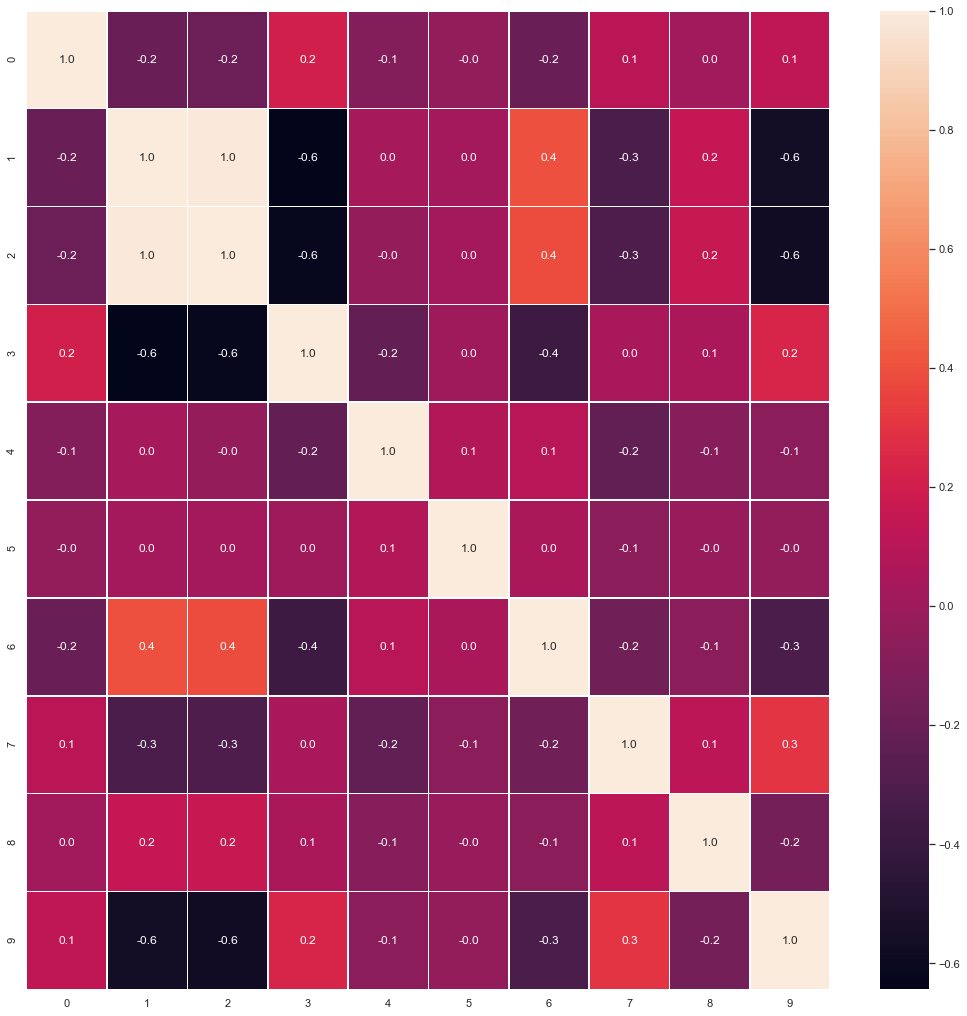

In [ ]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(corrmatrix, annot=True, linewidths=.5, fmt= '.1f',ax=ax)


In [ ]:
data5.columns

['Summary',
 'Temperature',
 'Apparent_temp',
 'Humidity',
 'Wind_Speed',
 'Wind_Bearing',
 'Visibility',
 'Pressure',
 'month',
 'Precip_Type']

<table align="left">
    <tr>
        <td width="8%">
            <img src="note.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
<b>From heatmap we can see that Temperature is highly correlated with Apparent Temperature</b>     </font>
            </div>
        </td>
    </tr>
</table>


In [ ]:
data_selected = data5.select('*')

<a id="Data_Transformation"> </a>
## 7. Data Transformation


**To standardize data we need to convert them into a vector using vector assembler and then apply scaler**<br>
To do so we will use pipelining

In [ ]:
X = data_selected.select("*").drop('Apparent_temp')
X.columns

['Summary',
 'Temperature',
 'Humidity',
 'Wind_Speed',
 'Wind_Bearing',
 'Visibility',
 'Pressure',
 'month',
 'Precip_Type']

In [ ]:
assembler = VectorAssembler(inputCols = X.columns , outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")


In [ ]:
pipeline = Pipeline(stages=[assembler, scaler])


In [ ]:
scalerModel = pipeline.fit(data_selected)

In [ ]:
scaled_data = scalerModel.transform(data_selected)

In [ ]:
# drop unscaled vectors
scaled_data = scaled_data.drop("features")
scaled_data.select(['features_scaled' , 'Apparent_temp' ]).show(5)

+--------------------+------------------+
|     features_scaled|     Apparent_temp|
+--------------------+------------------+
|[0.0,0.4643541393...|7.3888888888888875|
|[0.0,0.4622365634...| 7.227777777777776|
|[0.03846153846153...| 9.377777777777778|
|[0.0,0.4428758697...| 5.944444444444446|
|[0.03846153846153...| 6.977777777777779|
+--------------------+------------------+
only showing top 5 rows



In [ ]:
scaled_data.printSchema()

root
 |-- Summary: long (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Apparent_temp: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Wind_Speed: double (nullable = true)
 |-- Wind_Bearing: double (nullable = true)
 |-- Visibility: double (nullable = true)
 |-- Pressure: double (nullable = true)
 |-- month: long (nullable = true)
 |-- Precip_Type: double (nullable = true)
 |-- features_scaled: vector (nullable = true)



In [ ]:
finalized_data=scaled_data.select("features_scaled","Apparent_temp")
finalized_data.show(5)

+--------------------+------------------+
|     features_scaled|     Apparent_temp|
+--------------------+------------------+
|[0.0,0.4643541393...|7.3888888888888875|
|[0.0,0.4622365634...| 7.227777777777776|
|[0.03846153846153...| 9.377777777777778|
|[0.0,0.4428758697...| 5.944444444444446|
|[0.03846153846153...| 6.977777777777779|
+--------------------+------------------+
only showing top 5 rows



<a id="Linear_Regression"> </a>
## 8. Linear Regression


<table align="left">
    <tr>
        <td width="8%">
            <img src="key.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                    <b> Now we build our linear model<br><br>
                        In order to build a model, we do the following:<br>
                        1. Split the data<br>
                        2. Build the model<br>
                        3. Make predictions<br>
                        4. Compute the accuracy measures<br>
                        5. Tabulate the results <br>
                      </b>
                </font>
            </div>
        </td>
    </tr>
</table>

<a id="Split_the_data"> </a>
#### 8.1 Split the data


In [ ]:
train_data,test_data=finalized_data.randomSplit([0.75,0.25])


<a id="Build_the_model"> </a>
#### 8.2 Build the model


<i>Build the model</i>

In [ ]:
regressor = LinearRegression(featuresCol='features_scaled', labelCol='Apparent_temp')

<i>fit the model</i>

In [ ]:
regressor=regressor.fit(train_data)

<a id="Make_predictions"> </a>
#### 8.3 Make predictions


In [ ]:
pred_results = regressor.evaluate(test_data)

<a id="Performance_measures"> </a>
#### 8.4 Performance measures


<i>Coeffients of linear regression mpdel</i>

In [ ]:
regressor.coefficients

DenseVector([-0.1792, 61.6422, 0.9107, -2.7192, 0.1584, -0.0017, 1.0523, -0.0381, -0.4474])

<i>intercept of linear regression mpdel</i>

In [ ]:
regressor.intercept

-20.679119315285693

In [ ]:
regressor.summary.meanSquaredError

1.0293615482016807

In [ ]:
regressor.summary.r2

0.9909825334313082

In [ ]:
regressor.summary.r2adj

0.9909813558918192

In [ ]:
regressor.summary.rootMeanSquaredError

1.0145745651265266

<a id="Tabulate_Result"> </a>
#### 8.5 Tabulate Result


In [ ]:
rows = [('Model' , 'R-squared' , 'Adj R-squared' , 'RMSE'),('Linear Regression' , str(regressor.summary.r2) ,  str(regressor.summary.r2adj) ,  str(regressor.summary.rootMeanSquaredError))]
result = spark.createDataFrame(data=rows)


<a id="Conclusion"> </a>
## 9. Conclusion

In [ ]:
result.show()

+-----------------+------------------+------------------+------------------+
|               _1|                _2|                _3|                _4|
+-----------------+------------------+------------------+------------------+
|            Model|         R-squared|     Adj R-squared|              RMSE|
|Linear Regression|0.9909825334313082|0.9909813558918192|1.0145745651265266|
+-----------------+------------------+------------------+------------------+



<table align="left">
    <tr>
        <td width="8%">
            <img src="note.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                    <b>We have built a linear regression model in spark with RMSE score of 1.0145</b>
                </font>
            </div>
        </td>
    </tr>
</table>